In [2754]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from arch import arch_model
from statsmodels.tsa.ardl import ARDL
from sklearn.model_selection import TimeSeriesSplit

In [2755]:
goods_df = pd.read_csv("../clean_data/global_commodity_prices.csv")
goods_df["Date"] = pd.to_datetime(goods_df["Date"], errors="coerce", format="%m/%Y")
goods_df["Date"] = pd.PeriodIndex(goods_df["Date"], freq="M")

In [2756]:
X = sm.add_constant(goods_df[["Tea", "Sugar"]])
Y = goods_df["Coffee"]

model = sm.OLS(Y, X).fit()

print(model.summary())

print(f"\nCoefficients:")
print(f"Intercept: {model.params["const"]}")
print(f"Coefficient for Tea: {model.params["Tea"]}")
print(f"Coefficient for Sugar (PSUGAISAUSDM): {model.params["Sugar"]}")
print(f"\nR-squared: {model.rsquared}")

                            OLS Regression Results                            
Dep. Variable:                 Coffee   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     336.3
Date:                Tue, 11 Mar 2025   Prob (F-statistic):           7.49e-88
Time:                        15:55:30   Log-Likelihood:                -189.31
No. Observations:                 422   AIC:                             384.6
Df Residuals:                     419   BIC:                             396.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0248      0.079      0.313      0.7

In [2757]:
brl_df = pd.read_csv("../clean_data/brl_data_clean.csv")
vnd_df = pd.read_csv("../clean_data/vnd_data_clean.csv")
cop_df = pd.read_csv("../clean_data/cop_data_clean.csv")
idr_df = pd.read_csv("../clean_data/idr_data_clean.csv")
hnl_df = pd.read_csv("../clean_data/hnl_data_clean.csv")

xr_df = brl_df
for df in [vnd_df, cop_df, idr_df, hnl_df]:
    xr_df = pd.merge(xr_df, df, on="Date", how="inner")

xr_df["Date"] = pd.to_datetime(xr_df["Date"], errors="coerce", format="%m/%Y")
xr_df["Date"] = pd.PeriodIndex(xr_df["Date"], freq="M")

In [2758]:
merge_df = pd.merge(goods_df, xr_df, on="Date", how="inner")
merge_df

,Date,Coffee,Milk,Sugar,Tea,brl Exchange Rate,vnd Exchange Rate,cop Exchange Rate,idr Exchange Rate,hnl Exchange Rate
0,1990-01,0.758300,NaN,0.142000,1.147273,0.000006,5479.329529,440.08,1804.850000,2.0000
1,1990-02,0.840100,NaN,0.146500,0.958396,0.000010,5479.329529,451.72,1809.870000,2.0000
2,1990-03,0.939600,NaN,0.153100,0.873620,0.000016,5479.329529,463.40,1820.350000,4.0000
3,1990-04,0.937300,NaN,0.152400,0.883644,0.000021,5479.329529,474.62,1826.050000,4.0000
4,1990-05,0.920200,NaN,0.146200,0.848309,0.000023,5563.430866,485.99,1831.400000,4.2000
...,...,...,...,...,...,...,...,...,...,...
414,2024-07,2.570987,0.242129,0.193517,1.363518,5.541448,24251.560000,4036.80,16261.652826,24.8582
415,2024-08,2.614377,0.244700,0.184195,1.467152,5.552014,24245.850000,4062.98,15793.181818,24.8826
416,2024-09,2.787605,0.251466,0.206248,1.572990,5.540967,24163.540000,4191.86,15341.250000,24.8381
417,2024-10,2.767774,0.238592,0.223552,1.490232,5.623509,24192.520000,4257.76,15541.347826,24.9661


In [2759]:
Z = sm.add_constant(merge_df[["Tea", "Sugar", "brl Exchange Rate", "vnd Exchange Rate", "cop Exchange Rate", 
                              "idr Exchange Rate", "hnl Exchange Rate"]])
W = merge_df["Coffee"]

model = sm.OLS(W, Z).fit()

print(model.summary())

print(f"\nCoefficients:")
print(f"Intercept: {model.params["const"]}")
print(f"Coefficient for tea (PTEAUSDM): {model.params["Tea"]}")
print(f"Coefficient for sugar (PSUGAISAUSDM): {model.params["Sugar"]}")
print(f"Coefficient for Brazil Exchange Rate: {model.params["brl Exchange Rate"]}")
print(f"Coefficient for Vietnam Exchange Rate: {model.params["vnd Exchange Rate"]}")
print(f"Coefficient for Colombia Exchange Rate: {model.params["cop Exchange Rate"]}")
print(f"Coefficient for Indonesia Exchange Rate: {model.params["idr Exchange Rate"]}")
print(f"Coefficient for Honduras Exchange Rate: {model.params["hnl Exchange Rate"]}")
print(f"\nR-squared: {model.rsquared}")

                            OLS Regression Results                            
Dep. Variable:                 Coffee   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     138.7
Date:                Tue, 11 Mar 2025   Prob (F-statistic):          4.69e-104
Time:                        15:55:30   Log-Likelihood:                -114.01
No. Observations:                 419   AIC:                             244.0
Df Residuals:                     411   BIC:                             276.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2090      0.09

In [2760]:
result = adfuller(merge_df["Coffee"])
print(f"ADF Statistic: {result[0]}")
print(f"P-Value: {result[1]}")

ADF Statistic: -1.7881037924831735
P-Value: 0.3863836197218491


In [2761]:
merge_df["coffee_diff"] = merge_df["Coffee"].diff()

merge_df["coffee_diff"] = merge_df["coffee_diff"].replace([np.inf, -np.inf], np.nan)

merge_df = merge_df.dropna(subset=["coffee_diff"])

In [2762]:
result = adfuller(merge_df["coffee_diff"])
print(f"ADF Statistic: {result[0]}")
print(f"P-Value: {result[1]}")

ADF Statistic: -11.585252397836792
P-Value: 2.877944863970424e-21


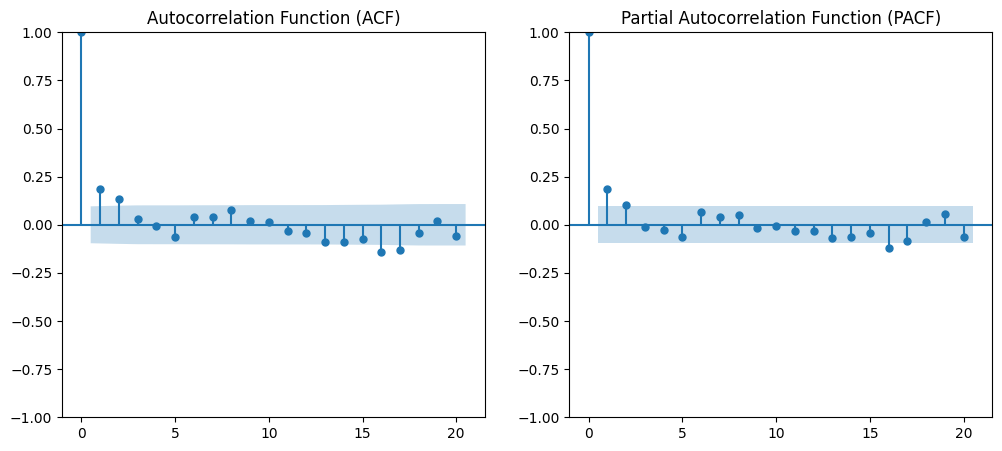

In [2763]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

plot_acf(merge_df["coffee_diff"], lags=20, ax=ax[0])
ax[0].set_title("Autocorrelation Function (ACF)")

plot_pacf(merge_df["coffee_diff"], lags=20, ax=ax[1])
ax[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()

<div align="center">
  ARMA(1,1) Model
</div>

In [2764]:
model = ARIMA(merge_df['coffee_diff'], order=(1, 1, 1))
fitted_model = model.fit()
print(fitted_model.summary())

c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            coffee_diff   No. Observations:                  418
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 338.275
Date:                Tue, 11 Mar 2025   AIC                           -670.551
Time:                        15:55:31   BIC                           -658.451
Sample:                             0   HQIC                          -665.767
                                - 418                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1940      0.027      7.287      0.000       0.142       0.246
ma.L1         -0.9999      0.570     -1.755      0.079      -2.116       0.117
sigma2         0.0114      0.006      1.761      0.0

In [2765]:
merge_df["Time"] = merge_df["Date"]
merge_df["Time"] = merge_df["Time"].astype(str)
merge_df.set_index("Time",inplace=True)

C:\Users\nicol\AppData\Local\Temp\ipykernel_2252\3281918271.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_df["Time"] = merge_df["Date"]
C:\Users\nicol\AppData\Local\Temp\ipykernel_2252\3281918271.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_df["Time"] = merge_df["Time"].astype(str)


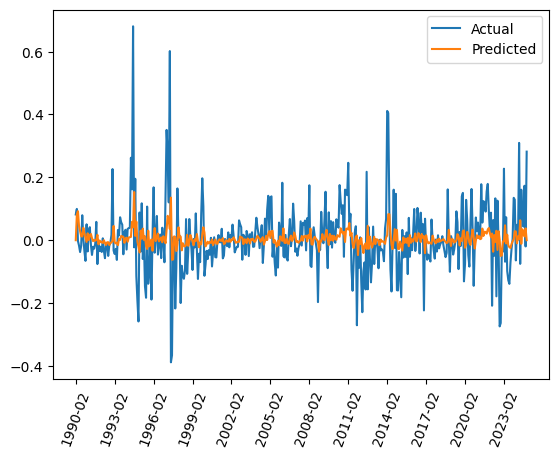

In [2766]:
predicted_returns = fitted_model.fittedvalues

plt.plot(merge_df["coffee_diff"], label="Actual")
plt.plot(merge_df.index, predicted_returns, label="Predicted")
plt.legend()

tick_interval = 36
plt.xticks(range(0, len(merge_df), tick_interval), rotation=70)

plt.show()

In [2767]:
predicted_returns = fitted_model.fittedvalues

mse = mean_squared_error(merge_df["coffee_diff"], predicted_returns)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.011505280951172415


<div align="center">
  GARCH(1,1) Model
</div>

In [2768]:
returns = merge_df['coffee_diff'].dropna()

garch_model = arch_model(merge_df['coffee_diff'].dropna(), vol='Garch', p=1, q=1)

garch_result = garch_model.fit()

print(garch_result.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7894324.793709117
Iteration:      2,   Func. Count:     16,   Neg. LLF: 16895.654832663527
Iteration:      3,   Func. Count:     23,   Neg. LLF: -355.0301763545035
Iteration:      4,   Func. Count:     30,   Neg. LLF: -84.29212852544927
Iteration:      5,   Func. Count:     37,   Neg. LLF: -345.8172147742008
Iteration:      6,   Func. Count:     43,   Neg. LLF: -389.80691297734666
Iteration:      7,   Func. Count:     50,   Neg. LLF: -390.88250149600265
Iteration:      8,   Func. Count:     55,   Neg. LLF: -390.8825420423191
Iteration:      9,   Func. Count:     59,   Neg. LLF: -390.8825420424929
Optimization terminated successfully    (Exit mode 0)
            Current function value: -390.8825420423191
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 9
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            coffee_diff   R-squared:     

c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0118. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


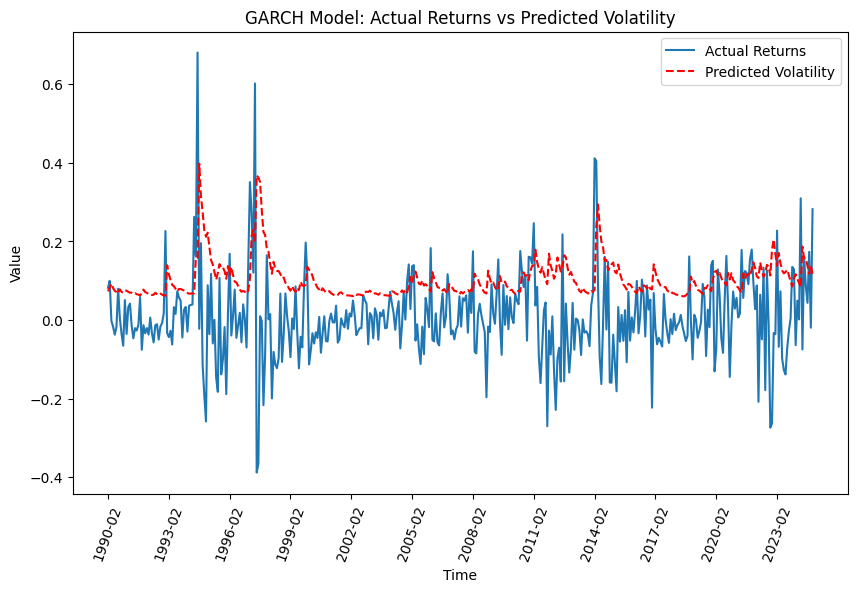

In [2769]:
predicted_volatility = garch_result.conditional_volatility

plt.figure(figsize=(10, 6))
plt.plot(merge_df['coffee_diff'].dropna(), label='Actual Returns')
plt.plot(predicted_volatility, label='Predicted Volatility', color='red', linestyle='--')
plt.legend()
plt.title('GARCH Model: Actual Returns vs Predicted Volatility')
plt.xlabel('Time')
plt.ylabel('Value')
tick_interval = 36
plt.xticks(range(0, len(merge_df), tick_interval), rotation=70)
plt.show()

In [2770]:
mse = np.mean((returns - predicted_volatility) ** 2)
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 0.02422042701650273


<div align="center">
  GARCH-M(1,1) Model
</div>

In [2771]:
returns = merge_df['coffee_diff'].dropna()

garch_m_model = arch_model(returns, vol='Garch', p=1, q=1, mean='Constant')
garch_m_result = garch_m_model.fit()

print(garch_m_result.summary())

predicted_volatility = garch_m_result.conditional_volatility

mu = garch_m_result.params['mu']
omega = garch_m_result.params['omega']
alpha = garch_m_result.params['alpha[1]']
beta = garch_m_result.params['beta[1]']

conditional_mean = mu + alpha * returns.shift(1) + beta * predicted_volatility.shift(1)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7894324.793709117
Iteration:      2,   Func. Count:     16,   Neg. LLF: 16895.654832663527
Iteration:      3,   Func. Count:     23,   Neg. LLF: -355.0301763545035
Iteration:      4,   Func. Count:     30,   Neg. LLF: -84.29212852544927
Iteration:      5,   Func. Count:     37,   Neg. LLF: -345.8172147742008
Iteration:      6,   Func. Count:     43,   Neg. LLF: -389.80691297734666
Iteration:      7,   Func. Count:     50,   Neg. LLF: -390.88250149600265
Iteration:      8,   Func. Count:     55,   Neg. LLF: -390.8825420423191
Iteration:      9,   Func. Count:     59,   Neg. LLF: -390.8825420424929
Optimization terminated successfully    (Exit mode 0)
            Current function value: -390.8825420423191
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 9
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            coffee_diff   R-squared:     

c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0118. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


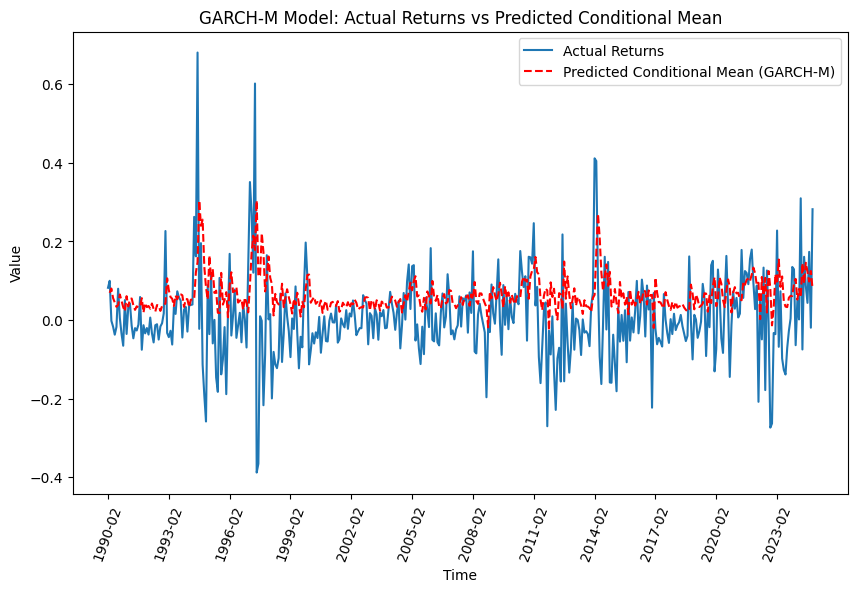

In [2772]:
plt.figure(figsize=(10, 6))
plt.plot(returns, label='Actual Returns')
plt.plot(conditional_mean, label='Predicted Conditional Mean (GARCH-M)', color='red', linestyle='--')
plt.legend()
plt.title('GARCH-M Model: Actual Returns vs Predicted Conditional Mean')
plt.xlabel('Time')
plt.ylabel('Value')
tick_interval = 36
plt.xticks(range(0, len(merge_df), tick_interval), rotation=70)
plt.show()

In [2773]:
conditional_mean = mu + alpha * returns.shift(1)**2 + beta * predicted_volatility**2

mse = np.mean((returns - conditional_mean) ** 2)
print(f'Mean Squared Error (MSE) of the GARCH-M Model: {mse}')

Mean Squared Error (MSE) of the GARCH-M Model: 0.012609165962833754


<div align="center">
  ARDL(1,1) Model
</div>

In [2774]:
merge_df["tea_diff"] = merge_df["Tea"].diff().dropna()
merge_df["tea_diff"].dropna(inplace=True)

merge_df["sugar_diff"] = merge_df["Sugar"].diff().dropna()
merge_df["sugar_diff"].dropna(inplace=True)

merge_df["milk_diff"] = merge_df["Milk"].diff().dropna()
merge_df["sugar_diff"].dropna(inplace=True)

merge_df["brl_diff"] = merge_df["brl Exchange Rate"].diff().dropna()
merge_df["brl_diff"].dropna(inplace=True)

merge_df["vnd_diff"] = merge_df["vnd Exchange Rate"].diff().dropna()
merge_df["vnd_diff"].dropna(inplace=True)

merge_df["cop_diff"] = merge_df["cop Exchange Rate"].diff().dropna()
merge_df["cop_diff"].dropna(inplace=True)

merge_df["idr_diff"] = merge_df["idr Exchange Rate"].diff().dropna()
merge_df["idr_diff"].dropna(inplace=True)

merge_df["hnl_diff"] = merge_df["hnl Exchange Rate"].diff().dropna()
merge_df["hnl_diff"].dropna(inplace=True)

C:\Users\nicol\AppData\Local\Temp\ipykernel_2252\3933167404.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_df["tea_diff"] = merge_df["Tea"].diff().dropna()
C:\Users\nicol\AppData\Local\Temp\ipykernel_2252\3933167404.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_df["tea_diff"].dropna(inplace=True)
C:\Users\nicol\AppData\Local\Temp\ipykernel_2252\3933167404.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [2775]:
y = merge_df["coffee_diff"].dropna()
X = merge_df[["tea_diff", "sugar_diff", "milk_diff", "brl_diff", "vnd_diff", "cop_diff", 
                              "idr_diff", "hnl_diff"]].dropna()

In [2776]:
y = y.dropna()
X = X.dropna()

y, X = y.align(X, join="inner")

y.index = pd.to_datetime(y.index)
X.index = pd.to_datetime(X.index)

model = ARDL(y, lags=(1), exog=X, order=(1, 0))
model_fitted = model.fit()

print(model_fitted.summary())

                                     ARDL Model Results                                    
Dep. Variable:                         coffee_diff   No. Observations:                  376
Model:             ARDL(1, 1, 1, 1, 1, 1, 1, 1, 1)   Log Likelihood                 305.989
Method:                            Conditional MLE   S.D. of innovations              0.107
Date:                             Tue, 11 Mar 2025   AIC                           -573.978
Time:                                     15:55:32   BIC                           -499.367
Sample:                                 09-01-1993   HQIC                          -544.357
                                      - 11-01-2024                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0013      0.007      0.182      0.855      -0.013       0.016
coffee_diff.L1 

c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


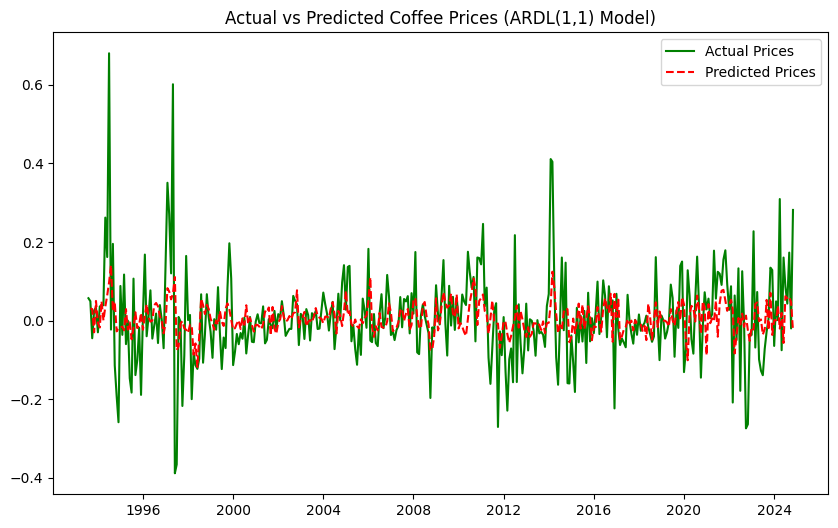

In [2777]:
plt.figure(figsize=(10, 6))
plt.plot(y, label="Actual Prices", color="green")
plt.plot(model_fitted.fittedvalues, label="Predicted Prices", color="red", linestyle="--")
plt.title("Actual vs Predicted Coffee Prices (ARDL(1,1) Model)")
plt.legend()
plt.show()

In [2778]:
y_actual = y.loc[model_fitted.fittedvalues.index]

mse = mean_squared_error(y_actual, model_fitted.fittedvalues)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.011449390621306062


<div align="center">
  ARIMA(1,1) Model Forecasting
</div>

In [2779]:
model = ARIMA(merge_df['coffee_diff'], order=(1, 1, 1))
fitted_model = model.fit()

forecasted_values = fitted_model.forecast(steps=36)

c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


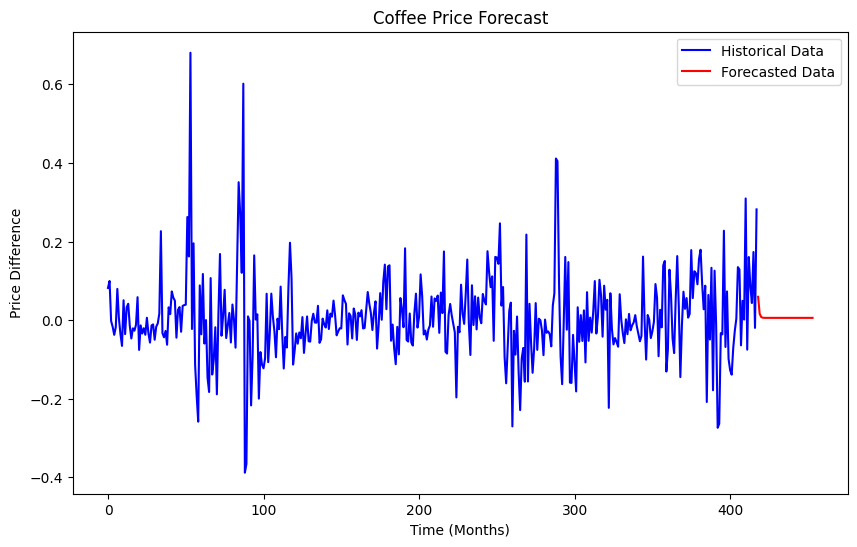

In [2780]:
plt.figure(figsize=(10, 6))

plt.plot(range(len(merge_df['coffee_diff'])), merge_df['coffee_diff'], label='Historical Data', color='blue')

plt.plot(range(len(merge_df['coffee_diff']), len(merge_df['coffee_diff']) + 36), forecasted_values, label='Forecasted Data', color='red')

plt.title('Coffee Price Forecast')
plt.xlabel('Time (Months)')
plt.ylabel('Price Difference')
plt.legend()
plt.show()

In [2781]:
mse = mean_squared_error(merge_df['coffee_diff'], fitted_model.fittedvalues)
print(f'Mean Squared Error (MSE) of the model: {mse}')

Mean Squared Error (MSE) of the model: 0.011505280951172415


<div align="center">
  GARCH(1,1) Model Forecasting
</div>

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7894324.793709117
Iteration:      2,   Func. Count:     16,   Neg. LLF: 16895.654832663527
Iteration:      3,   Func. Count:     23,   Neg. LLF: -355.0301763545035
Iteration:      4,   Func. Count:     30,   Neg. LLF: -84.29212852544927
Iteration:      5,   Func. Count:     37,   Neg. LLF: -345.8172147742008
Iteration:      6,   Func. Count:     43,   Neg. LLF: -389.80691297734666
Iteration:      7,   Func. Count:     50,   Neg. LLF: -390.88250149600265
Iteration:      8,   Func. Count:     55,   Neg. LLF: -390.8825420423191
Iteration:      9,   Func. Count:     59,   Neg. LLF: -390.8825420424929
Optimization terminated successfully    (Exit mode 0)
            Current function value: -390.8825420423191
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 9


c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0118. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


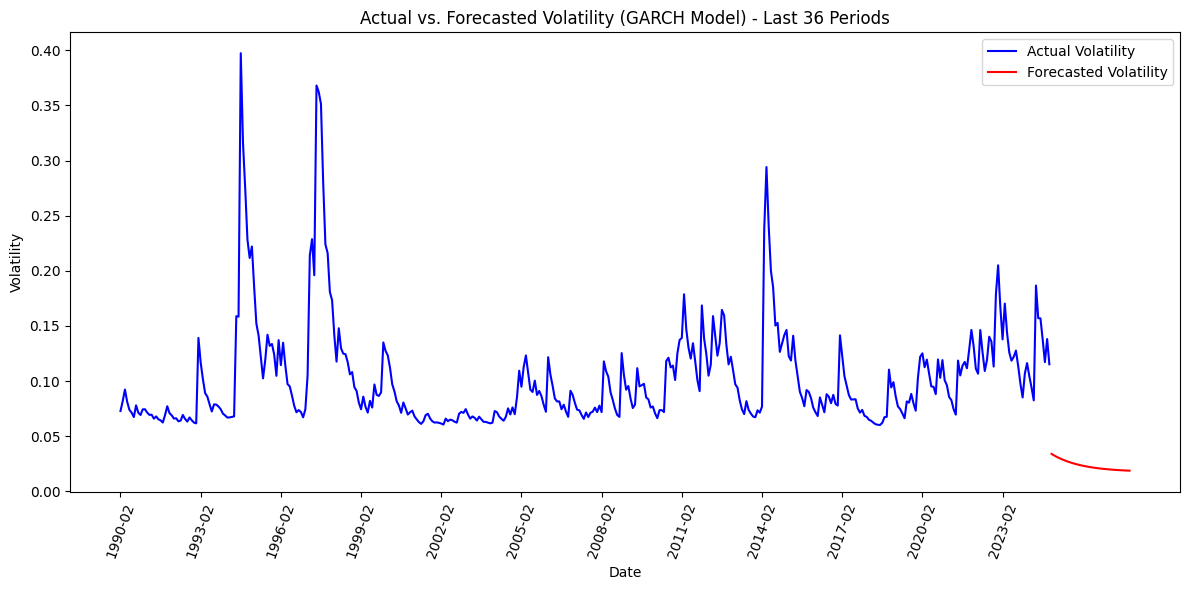

In [2782]:
returns = merge_df['coffee_diff'].dropna()
garch_model = arch_model(returns, vol='Garch', p=1, q=1)
garch_result = garch_model.fit()

# Predicted volatility (conditional volatility)
predicted_volatility = garch_result.conditional_volatility

# Forecast the next 36 periods
forecast_horizon = 36
garch_forecast = garch_result.forecast(horizon=forecast_horizon)

# Forecasted volatility for the next 36 periods
forecasted_volatility = garch_forecast.variance.values[-1, :]

# Plot actual vs forecasted volatility
plt.figure(figsize=(12, 6))

# Plot actual volatility (conditional volatility)
plt.plot(merge_df.index, predicted_volatility, label="Actual Volatility", color='blue')

# Plot forecasted volatility for the last 36 periods
plt.plot(range(len(merge_df), len(merge_df) + forecast_horizon), forecasted_volatility, label="Forecasted Volatility", color='red')

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Actual vs. Forecasted Volatility (GARCH Model) - Last 36 Periods")
plt.legend()

# Customize x-axis ticks
tick_interval = 36
plt.xticks(range(0, len(merge_df), tick_interval), rotation=70)

plt.tight_layout()
plt.show()

In [2783]:
mse = mean_squared_error(merge_df["coffee_diff"].iloc[-36:], forecasted_volatility)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.019094504844984192


<div align="center">
  GARCH-M(1,1) Model Forecasting
</div>

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1630969.266851986
Iteration:      2,   Func. Count:     16,   Neg. LLF: 6586.985385782638
Iteration:      3,   Func. Count:     22,   Neg. LLF: -61.17278805866465
Iteration:      4,   Func. Count:     28,   Neg. LLF: -53.459081527280276
Iteration:      5,   Func. Count:     34,   Neg. LLF: -14.815797658537724
Iteration:      6,   Func. Count:     40,   Neg. LLF: -58.41839803315103
Iteration:      7,   Func. Count:     46,   Neg. LLF: -65.59399272990774
Iteration:      8,   Func. Count:     51,   Neg. LLF: -59.57834993613347
Iteration:      9,   Func. Count:     57,   Neg. LLF: -65.82013413986209
Iteration:     10,   Func. Count:     62,   Neg. LLF: -65.82460519863055
Iteration:     11,   Func. Count:     67,   Neg. LLF: -65.83094180502104
Iteration:     12,   Func. Count:     72,   Neg. LLF: -65.83112609849093
Iteration:     13,   Func. Count:     77,   Neg. LLF: -65.83114497496388
Iteration:     14,   Func. Count:     81,   Neg. LL

c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01401. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01741. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\nicol\AppData

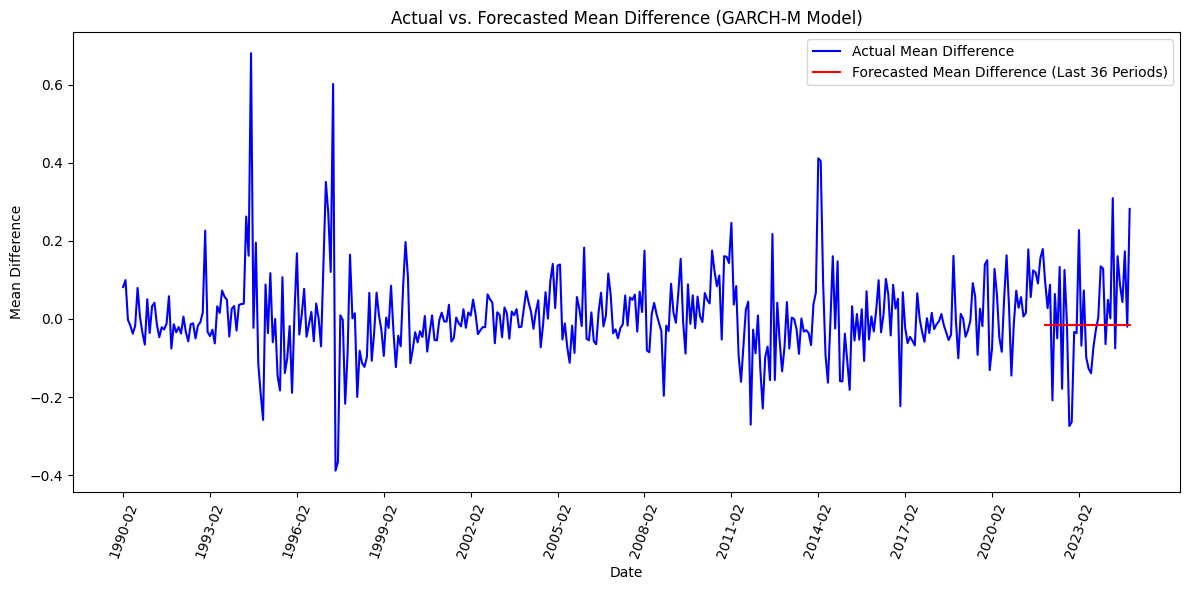

In [2784]:
returns = merge_df['coffee_diff'].dropna()

tscv = TimeSeriesSplit(n_splits=5)

predictions = []
actual_data = returns[-36:]

for train_index, test_index in tscv.split(returns[:-36]):
    train_data, test_data = returns.iloc[train_index], returns.iloc[test_index]
    
    garch_m_model = arch_model(train_data, vol='Garch', p=1, q=1, mean='Constant')
    garch_m_result = garch_m_model.fit()

    garch_m_forecast = garch_m_result.forecast(horizon=36)
    forecasted_mean = garch_m_forecast.mean.values[-1, :]
    
    predictions.append(forecasted_mean)

predicted_mean = predictions[0]

plt.figure(figsize=(12, 6))

plt.plot(returns.index, returns, label="Actual Mean Difference", color='blue')

plt.plot(actual_data.index, predicted_mean, label="Forecasted Mean Difference (Last 36 Periods)", color='red')

plt.xlabel("Date")
plt.ylabel("Mean Difference")
plt.title("Actual vs. Forecasted Mean Difference (GARCH-M Model)")
plt.legend()

tick_interval = 36
plt.xticks(range(0, len(merge_df), tick_interval), rotation=70)

plt.tight_layout()
plt.show()

In [2785]:
mse = mean_squared_error(actual_data, predicted_mean)
print(f"Mean Squared Error for the last 36 periods: {mse}")

Mean Squared Error for the last 36 periods: 0.01948685133708334


<div align="center">
  ARDL(1,1) Model Forecasting
</div>

In [2786]:
y = merge_df["coffee_diff"].dropna()
X = merge_df[["tea_diff", "sugar_diff", "brl_diff", "vnd_diff", "cop_diff", 
                              "idr_diff", "hnl_diff"]].dropna()

c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes,

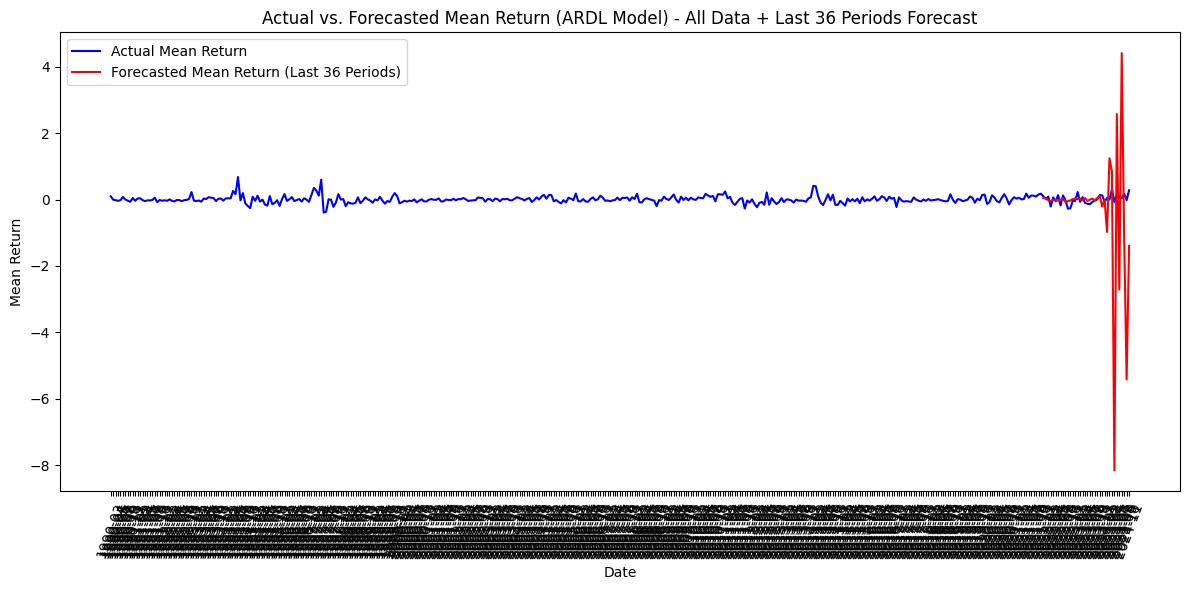

In [2787]:
y, X = y.align(X, join="inner")

tscv = TimeSeriesSplit(n_splits=5)

predictions = []
actual_data = y[-36:]

for train_index, test_index in tscv.split(y[:-36]):
    train_y, test_y = y.iloc[train_index], y.iloc[test_index]
    train_X, test_X = X.iloc[train_index], X.iloc[test_index]
    
    model = ARDL(train_y, lags=(1), exog=train_X, order=(1, 0))
    model_fitted = model.fit()

    forecast = model_fitted.predict(start=len(train_y), end=len(train_y) + 35, exog_oos=test_X)

    predictions.append(forecast)

predicted_mean = predictions[0]

plt.figure(figsize=(12, 6))

plt.plot(y.index, y, label="Actual Mean Return", color='blue')

plt.plot(actual_data.index, predicted_mean, label="Forecasted Mean Return (Last 36 Periods)", color='red')

plt.xlabel("Date")
plt.ylabel("Mean Return")
plt.title("Actual vs. Forecasted Mean Return (ARDL Model) - All Data + Last 36 Periods Forecast")
plt.legend()

plt.xticks(rotation=70)

plt.tight_layout()
plt.show()

In [2788]:
mse = mean_squared_error(y[-36:], forecast_values)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.018286240961027593
